In [1]:
#! /usr/bin/env python3
# Import packages
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.linear_model import Ridge 
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
def Optimize_regression(x,y,x_valid,y_valid):
    # The model of choice goes here
    print("Setting up models...")
    BO_model_RFR = RFR(random_state=1,n_estimators=100)
    BO_model_DTR = DTR(random_state=1)
    BO_model_Ridge = Ridge(random_state=1,alpha=1)
    BO_model_Bayes_Ridge = BayesianRidge()
    BO_model_SVR = svm.SVR(gamma='scale')
    BO_model_EN = ElasticNet()
    BO_model_Lasso = Lasso()

    d =    {'Model_Name': [
            "Random Forest Regression",
            "Decision Tree Regression",
            #"Ridge",
            "Bayes_Ridge",
            'Support Vector Regression',
            #'Elastic_Net',
            'Lasso',
            ],
            
            'Model': [
            BO_model_RFR,
            BO_model_DTR,
            #BO_model_Ridge,
            BO_model_Bayes_Ridge,
            BO_model_SVR,
            #BO_model_EN,
            BO_model_Lasso
            
        ],
        'MAE': [0.0,0.0,0.0,0.0,0.0],#0.0,0.0],
        'Fit_Time' : [0.0, 0.0, 0.0, 0.0, 0.0],#0.0,0.0]
        }
    
    df = pd.DataFrame(data=d)
    
    for i,m_type in enumerate(df["Model"]):
        # time before
        time_a = time.time()
        # fit
        m_type.fit(x,y.values.ravel())
        df['MAE'].values[i] = mean_absolute_error(y_valid, m_type.predict(x_valid))
        # time after
        time_b = time.time()
        df['Fit_Time'].values[i] = time_b - time_a
    # best model
    min_mod = df['Model_Name'][df['MAE']==df['MAE'].min()]
    return(df,min_mod.iloc[0])

In [3]:
#Load the training set and the test set
print('Reading in data...')
BO_train, BO_valid = train_test_split(pd.read_csv('train.csv'))
BO_submit = pd.read_csv('test.csv')

#The columns I care about (for now)
BO_columns = ["budget","runtime","revenue"]

#Columns in X data and Y data, respectively
BO_in = ["budget","runtime"]
BO_out = ["revenue"]

#Trim the train and test data
BO_train=BO_train[BO_columns]
BO_valid=BO_valid[BO_columns]

#Estimate values for which there is no data
my_imputer = SimpleImputer()
imputed_BO_train = pd.DataFrame(my_imputer.fit_transform(BO_train))
imputed_BO_valid = pd.DataFrame(my_imputer.transform(BO_valid))

#Reset the column names to that of the data
imputed_BO_train.columns = BO_train.columns
imputed_BO_valid.columns = BO_valid.columns

#Split the data into training and testing data
x = imputed_BO_train[BO_in]
y = imputed_BO_train[BO_out]
x_valid = imputed_BO_valid[BO_in]
y_valid = imputed_BO_valid[BO_out]

#Find the best mml model
Models_df,mname = Optimize_regression(x,y,x_valid,y_valid) 

Reading in data...
Setting up models...


/usr/lib/python3.8/site-packages/sklearn/linear_model/coordinate_descent.py:473: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.056687002865966e+18, tolerance: 4347238191841390.0
  model = cd_fast.enet_coordinate_descent(


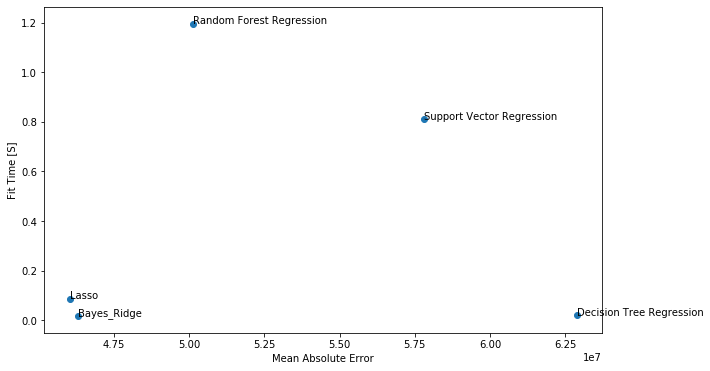

In [5]:
#print('Best model for this data (default settings):',mname)

#print(Models_df)
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x=Models_df['MAE'].to_numpy(),y=Models_df['Fit_Time'].to_numpy())
for i, txt in enumerate(Models_df['Model_Name'].to_numpy()):
	ax.annotate(txt,(Models_df['MAE'].to_numpy()[i],Models_df['Fit_Time'].to_numpy()[i]))
plt.xlabel('Mean Absolute Error')
plt.ylabel('Fit Time [S]')
plt.show()